# Тестовое задание от AVSOFT

**Задача:**   
Выявить зависимость числа `bugs` от значений признаков `repository_name`, `commit_hash`, `commit_date`, `commit_author` и `commit_message`.  
Реализовать модель, на основе данного датасета, которая с максимальной точностью сможет предсказывать количество `bugs`.

**Описание данных:**  
В данных содержится 5 признаков и 1 целевая переменная.
- `repository_name` - наименование репозитория
- `commit_hash` - хэш коммита
- `commit_date` - дата коммита
- `commit_author` - автор коммита
- `commit_message` - сообщение, отправленное вместе с коммитом
- `bugs` - количество ошибок (целевой признак)

# Импорт библиотек и настройка окружения

In [ ]:
!pip install shap
!pip install catboost
!pip install pymorphy2

import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en

import pandas as pd
import numpy as np
import warnings
import shap
import pymorphy2
import spacy
import string
import nltk
import re

from nltk.stem import WordNetLemmatizer 
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from catboost import CatBoostRegressor

from matplotlib import pyplot as plt

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

pd.set_option('display.max_columns', None)
warnings.simplefilter("ignore", (UserWarning, FutureWarning))

# 1. Загрузка данных

In [52]:
# Загрузим данные и сохраним их в переменной "data"
data = pd.read_csv('/content/drive/MyDrive/testovoe_avsoft/avsoft_data.csv')

# Выведем информацию о данных на экран
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repository_name  319 non-null    object
 1   commit_hash      319 non-null    object
 2   commit_date      319 non-null    object
 3   commit_author    319 non-null    object
 4   commit_message   319 non-null    object
 5   bugs             319 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 15.1+ KB


None

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7


In [53]:
# Посмотрм на уникальные значения столбцов и на их количество
for col in data.select_dtypes('object').columns:
  print(col)
  print(data[col].nunique())
  if data[col].nunique() <= 10:
      print(data[col].unique())
  print('-'*10)

repository_name
6
['mlm' 'standard' 'agent' 'conductor' 'dockers' 'sensor']
----------
commit_hash
319
----------
commit_date
318
----------
commit_author
10
['Victor' 'Peggy' 'Wendy' 'Trudy' 'Mallory' 'Eve' 'Dabe' 'Carol' 'Bob'
 'Alice']
----------
commit_message
309
----------


# 2. Исследовательский анализ данных

In [54]:
# Сделаем копию датафрейма
data_copy = data.copy()

# Создадим функцию, которая будет разбивать текст на токены
def tokenize(text):
  list_of_tokens = list()

  for token in nltk.word_tokenize(text):
    if (token in string.punctuation) or (token in string.printable): 
      continue
    list_of_tokens.append(token)
  return list_of_tokens

### Признак `repository_name`

In [ ]:
# Посотрим, сколько раз в данных встречается каждое из наименований репозиториев
data['repository_name'].value_counts()

conductor    114
sensor       102
mlm           41
standard      29
dockers       19
agent         14
Name: repository_name, dtype: int64

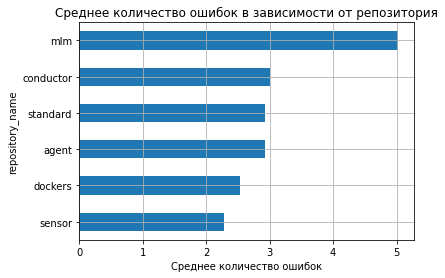

In [ ]:
data.groupby('repository_name')['bugs'].mean().sort_values().plot.barh(grid=True)
plt.title('Среднее количество ошибок в зависимости от репозитория')
plt.xlabel('Среднее количество ошибок');

Похоже, что в репозитории 'mlm' в среднем встречалосьбольше всего багов.

### Признак `commit_date`

In [ ]:
# Преобразуем столбце "commit_date" к формату "datetime"
data_copy['commit_date'] = pd.to_datetime(data['commit_date'])
# Извелечем месяц коммита из столбца "commit_date" и сохраним в столбец "commit_month"
data_copy['commit_month'] = pd.DatetimeIndex(data_copy['commit_date']).month
# Посмотрим на описание столбца "commit_date"
data_copy['commit_date'].describe()

count                     319
unique                    318
top       2020-06-10 10:17:03
freq                        2
first     2020-03-08 14:26:16
last      2020-06-12 14:26:12
Name: commit_date, dtype: object

Коммиты были сделаны в период с 8 марта 2020 года по 12 июня 2020 года. Период - 3 месяца.

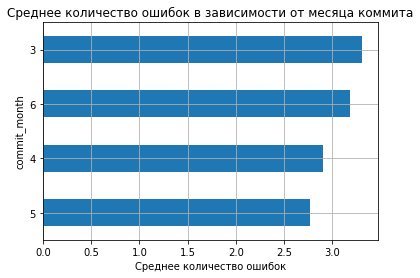

In [ ]:
# Посмотрим на зависимость среднего количества багов от месяца, когда был сделан коммит
data_copy.groupby('commit_month')['bugs'].mean().sort_values().plot.barh(grid=True)
plt.title('Среднее количество ошибок в зависимости от месяца коммита')
plt.xlabel('Среднее количество ошибок');

Значительно разницы в среднем количестве багов в зависимости от месяца коммита не наблюдается.

### Признак `commit_author`

In [ ]:
# Посмотрим, сколько раз каждый из авторов делал коммиты
data['commit_author'].value_counts()

Victor     134
Mallory     67
Wendy       48
Dabe        42
Trudy        9
Eve          9
Carol        4
Peggy        2
Bob          2
Alice        2
Name: commit_author, dtype: int64

Посмотрим на среднее количество багов, которое возникало у каждого автора.

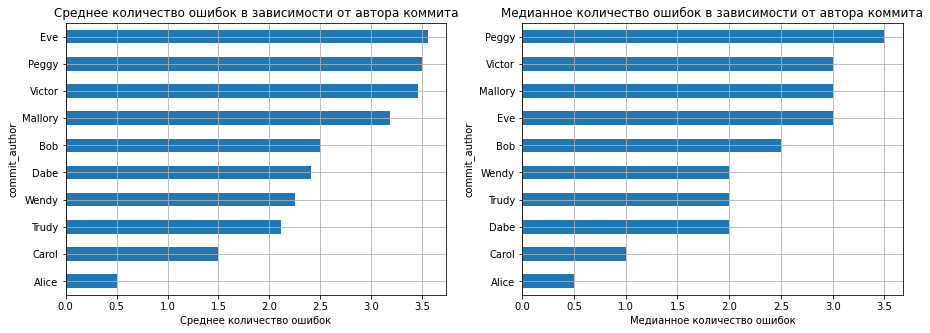

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

data.groupby('commit_author')['bugs'].mean().sort_values().plot.barh(grid=True, ax=ax[0]);
ax[0].set_title('Среднее количество ошибок в зависимости от автора коммита')
ax[0].set_xlabel('Среднее количество ошибок');

data.groupby('commit_author')['bugs'].median().sort_values().plot.barh(grid=True, ax=ax[1]);
ax[1].set_title('Медианное количество ошибок в зависимости от автора коммита')
ax[1].set_xlabel('Медианное количество ошибок');

Можно заметить, что есть сотрудники, у которых в среднем багов больше, нежели у другиx.

Посмотрим, какие сотрудники делали коммиты в те или иные репозитории.

In [ ]:
data.groupby('repository_name')['commit_author'].value_counts()

repository_name  commit_author
agent            Victor           14
conductor        Mallory          36
                 Dabe             35
                 Victor           18
                 Wendy            16
                 Trudy             6
                 Eve               3
dockers          Wendy             7
                 Carol             4
                 Mallory           3
                 Victor            3
                 Bob               2
mlm              Victor           39
                 Peggy             2
sensor           Victor           47
                 Mallory          28
                 Wendy             9
                 Dabe              7
                 Eve               6
                 Trudy             3
                 Alice             2
standard         Wendy            16
                 Victor           13
Name: commit_author, dtype: int64

Посмотрим также, в какое количество репозиториев сотрудники делали коммиты.

In [ ]:
data.groupby('commit_author')['repository_name'].agg([lambda x: x.nunique(), lambda x: x.count()])\
.rename(columns={'<lambda_0>': 'num_unique_repos', '<lambda_1>': 'total_commits'})\
.sort_values(by='num_unique_repos', ascending=False)

,num_unique_repos,total_commits
commit_author,,
Victor,6,134
Wendy,4,48
Mallory,3,67
Dabe,2,42
Eve,2,9
Trudy,2,9
Alice,1,2
Bob,1,2
Carol,1,4


Среди сотрудников есть те, кто делал коммитов значительно больше, нежели другие.

### Признак `bugs`

In [ ]:
# Посмотрим на описание столбца "bugs"
data['bugs'].describe()

count    319.000000
mean       2.996865
std        1.855636
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       12.000000
Name: bugs, dtype: float64

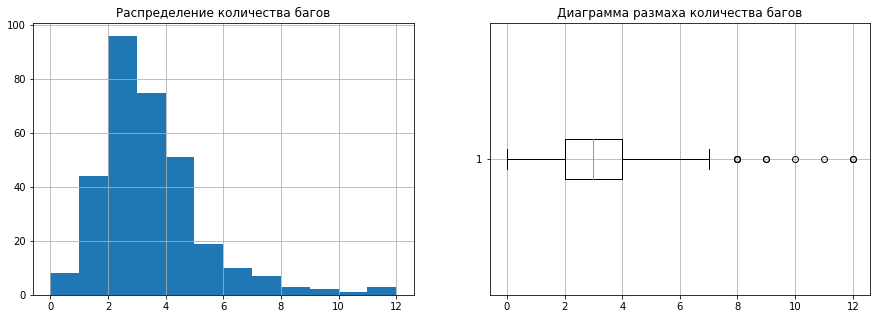

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(data['bugs'], bins=12)
ax[0].grid();
ax[0].set_title('Распределение количества багов')

ax[1].boxplot(data['bugs'], vert=False)
ax[1].grid();
ax[1].set_title('Диаграмма размаха количества багов');

Среднее количество багов за весь период равняется 3-м. Максимальное количество багов, появившееся при коммите - 12.

### Признак `commit_message`

In [ ]:
# Посмотрим на произвольные 5 строк столбца "commit_message"
data['commit_message'].sample(5, random_state=0)

314                                     setting hostname
267                                         noniterative
15     тип и всякие статичные данные пусть лежат в да...
65                                 Fix update_check_list
214                                            fix build
Name: commit_message, dtype: object

Сообщения состоят из русских и английских слов.

Посмотрим, как распределена длина сообщений.

In [ ]:
# Создадим столбец "commit_message_length" и сохраним в него длину сообщения
data_copy['commit_message_length'] = data_copy['commit_message'].apply(lambda x: len(tokenize(x)))

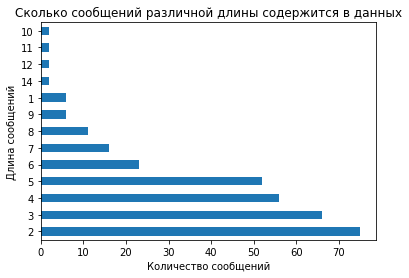

In [ ]:
data_copy['commit_message_length'].value_counts().plot.barh()
plt.ylabel("Длина сообщений")
plt.xlabel("Количество сообщений")
plt.title('Сколько сообщений различной длины содержится в данных');

Большинство сообщений короткие - в основном длина составляет примерно от 2-х до 5-и слов.  
Возможно, полезно будет создать такой признак, как "длина сообщения"

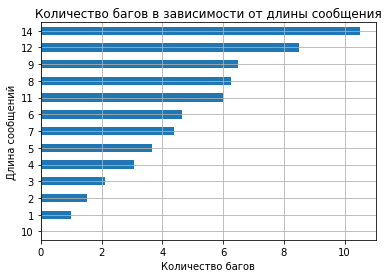

In [ ]:
data_copy.groupby('commit_message_length')['bugs'].mean().sort_values().plot.barh(grid=True);
plt.ylabel("Длина сообщений")
plt.xlabel("Количество багов")
plt.title('Количество багов в зависимости от длины сообщения');

Похоже, что наибольшее количество багов в основном наблюдалось у коммитов с более динными сообщениями.

Посмотрим на график разброса

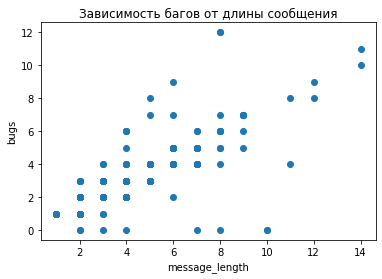

In [ ]:
plt.scatter(data_copy['commit_message_length'], data_copy['bugs']);
plt.title('Зависимость багов от длины сообщения')
plt.xlabel('message_length')
plt.ylabel('bugs');

In [ ]:
corr = data_copy['commit_message_length'].corr(data_copy['bugs'])
print('Коэффициент корреляции длины сообщения с количеством багов:', corr)

Коэффициент корреляции длины сообщения с количеством багов: 0.7631914930856488


У длины сообщения и количества багов присутствует линейная зависимость средней силы.

Посмотрим, какой длины сообщения в среднем писали сотрудники и сколько при этом совершали ошибок.

In [ ]:
df = data_copy.groupby('commit_author').agg({'commit_message_length': ['mean'], 'bugs': 'mean'}).sort_values(by=('bugs', 'mean'), ascending=False)
df

,commit_message_length,bugs
,mean,mean
commit_author,,
Eve,5.666667,3.555556
Peggy,5.000000,3.500000
Victor,4.261194,3.462687
Mallory,4.791045,3.179104
Bob,4.500000,2.500000
Dabe,2.952381,2.404762
Wendy,3.583333,2.250000
Trudy,2.888889,2.111111


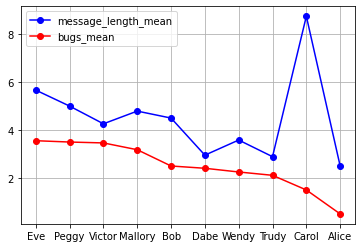

In [ ]:
plt.plot(df.index, df[('commit_message_length', 'mean')], '-bo', label='message_length_mean')
plt.plot(df.index, df[('bugs', 'mean')], '-ro', label='bugs_mean')
plt.legend()
plt.grid()

С одной стороны, может показаться, что чем длиннее сообщение, тем больше ошибок допускает сотрудник. Это однако это правило не работает для Carol, у которой при средней длине сообщений 8.7 слов - всего лишь в среднем 1.5 бага.

Посмотрим, какое количество ошибок совершают сотруднки в разных репозиториях.

In [ ]:
data_copy.pivot_table(index='repository_name', columns='commit_author', values='bugs', aggfunc='mean')

commit_author,Alice,Bob,Carol,Dabe,Eve,Mallory,Peggy,Trudy,Victor,Wendy
repository_name,,,,,,,,,,
agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.928571,NaN
conductor,NaN,NaN,NaN,2.600000,4.333333,3.333333,NaN,2.333333,3.833333,2.250000
dockers,NaN,2.5,1.5,NaN,NaN,4.000000,NaN,NaN,2.000000,2.714286
mlm,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,5.102564,NaN
sensor,0.5,NaN,NaN,1.428571,3.166667,2.892857,NaN,1.666667,2.234043,1.333333
standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.384615,2.562500


Посмотрим, какой длины сообщения пишут сотрудники в разных репозиториях.

In [ ]:
data_copy.pivot_table(index='repository_name', columns='commit_author', values='commit_message_length', aggfunc='mean')

commit_author,Alice,Bob,Carol,Dabe,Eve,Mallory,Peggy,Trudy,Victor,Wendy
repository_name,,,,,,,,,,
agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.071429,NaN
conductor,NaN,NaN,NaN,3.057143,5.666667,4.861111,NaN,3.000000,5.000000,3.937500
dockers,NaN,4.5,8.75,NaN,NaN,5.666667,NaN,NaN,3.333333,4.571429
mlm,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.102564,NaN
sensor,2.5,NaN,NaN,2.428571,5.666667,4.607143,NaN,2.666667,3.553191,2.666667
standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.692308,3.312500


Можно обратить внимание на Victor. Длина его сообщений в среднем и в репозитории mlm и в репозитории conductor равнялась 5 словам, однако в mlm в среднем у него было 5 багов, а в conductor - 3. Есть основания предпологать, что количество ошибок действительно может в некоторой степени зависеть от репозитория.

### Резюме

В ходе краткого исследовательского анализа было выявлено, что:  
- Количество багов варьируется в зависимости от названия репозитория (`repository_name`)
- Количество багов варьируется в зависимости от автора коммита (`commit_author`)
- Наибольшее количество багов в основном наблюдалось у коммитов с более длинными сообщениями. Коэффициент линейной корреляции Пирсона между количеством багов и длиной сообщения составляет 0.76. 
- Коммиты были сделаны в период с 8 марта 2020 года по 12 июня 2020 года.
- Среднее количество багов за весь период равняется 3-м. Максимальное количество багов - 12. Форма распределения количества багов близка к нормальному, однако имеет тяжелый хвост справа.


На основании проведенного анализа, можно выдвинуть несколько предположений:  
- Первое предположение: чем более длинное сообщение, тем больше ошибок будет в коммите.  
- Второе предположение: количество ошибок (как и длина сообщения) может зависеть от сотрудника.
- Третье предположение: возможно, некоторые сотрудники допускают больше багов в одних репозиториях, нежели в других. При этом, есть вероятность того, что при коммите, содержащим баг, сотрудник напишет более длинное сообщение.

Признаки `commit_hash` и `commit_date` будут исключены из датасета, так как они не несут пользы для дальнейшего обучения алгоритмов машинного обучения.   


# 3. Предобработка данных и создание новых признаков

На данном этапе, мы: 
- Осуществим предобработку столбца `commit_message`
- Создадим дополнительный признак - "длина сообщения".

In [55]:
# Данные, которые подвергнутся предобработке сохраним в переменную "data_pp"
data_pp = data.copy().drop(['commit_hash', 'commit_date'], axis=1)

In [56]:
# Создадим список стоп-слов на русском и английском языке
stopwords_rus = stopwords.words("russian")
stopwords_eng = stopwords.words("english")
stopwords_all = stopwords_rus + stopwords_eng

# Создадим функцию, которая будет делать токенизацию и лемматизацию предложения.
def tokenize_lemmatize(text):
  list_of_tokens = list()
  morph = pymorphy2.MorphAnalyzer()
  nlp = spacy.load('en',  disable=['parser', 'ner'])
  pattern = '[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]'
  # Приведем текст к нижнему регистру
  text = text.lower()
  # Уберем все специфические символы
  text = re.sub(pattern, ' ', text)

  for token in nltk.word_tokenize(text):
    if (token in string.punctuation) or (token in string.printable) or (token in stopwords_all): 
      continue
    token = morph.parse(token)[0].normal_form # Лемматизация русских слов
    doc = nlp(token)
    token = [tok.lemma_ for tok in doc][0] # Лемматизация английских слов
    list_of_tokens.append(token)
  return list_of_tokens

In [57]:
# Создадим признак "длина сообщения"
data_pp['message_length'] = data_pp['commit_message'].apply(tokenize).apply(len)

# Сделаем токенизацию и лемматизацию и сохраним список токенов в столбце "commit_message_pp"
data_pp['commit_message_pp'] = data_pp['commit_message'].apply(tokenize_lemmatize)

In [58]:
data_pp.head()

,repository_name,commit_author,commit_message,bugs,message_length,commit_message_pp
0,mlm,Victor,объяснения предсказаний с помощью lime,4,5,"[объяснение, предсказание, помощь, lime]"
1,mlm,Victor,Поставил lime вместо eli5,3,4,"[поставить, lime, вместо, eli5]"
2,mlm,Victor,Скрипт для создния пакетов обновления,4,5,"[скрипт, создние, пакет, обновление]"
3,mlm,Victor,Сортировка весов по убыванию,3,4,"[сортировка, вес, убывание]"
4,mlm,Victor,не надо конвертировать массив до операции по с...,7,9,"[конвертировать, массив, операция, смена, знак]"


In [59]:
# Создадим множество из всех уникальных слов, которые присутствуют в столбце "commit_message"
words_set = set([y for x in [l for l in data_pp['commit_message_pp'].values] for y in x])
# Отсортируем это множетсво и сохраним в список
words_list = sorted(list(words_set))
# Создадим словарь со всеми отсортированными уникальными словами, из столбца "commit_message"
word_dict = dict(zip([i for i in range(len(words_list))], [word for word in words_list]))

In [60]:
# Созадидим матрицу, в которой кол-во строк = кол-ву строк в датасете, а кол-во столбцов = кол-ву уникальных слов в столбце "commit_message"
wcount_array = np.zeros((data_pp.shape[0], len(word_dict)))
wcount_array.shape

(319, 548)

In [61]:
# Для каждого предложения создадим вектор, в котором стоит 1 - если слово встерчается в предложении, и 0 - если отсутсвует.
# Вектора сохраним в переменную "wcount_array"
for i in range(wcount_array.shape[0]):
    for j in range(wcount_array.shape[1]):
        val = word_dict[j] in data_pp['commit_message_pp'][i]
        wcount_array[i, j] = val

In [62]:
# Сохраним вектора с предложениями в переменную `word_features` в формате DataFrame.  
word_features = pd.DataFrame(wcount_array, index=data_pp.index, columns=word_dict.values(), dtype=np.int8)

# Сохраним оставшиеся признаки в переменную `main_features`
main_features = data_pp[['repository_name', 'commit_author', 'message_length']]

# Сохраним все признаки в переменную "all_features"
all_features = main_features.merge(word_features, left_index=True, right_index=True)

# Сгенерируем также признак, который будет содержать случайные числа, распределенные равномерно.
np.random.seed(1)
rand_array = np.random.randint(main_features['message_length'].min(), main_features['message_length'].max(), main_features.shape[0])
# Сохраним датасет из основных признаков + случайный признак в переменную "main_features_rand"
main_features_rand = main_features.copy() 
main_features_rand['rand_feature'] = rand_array

# Сохраним целевой признак в переменную `target`
target = data_pp['bugs']

# Сохраним список категориальных столбцов в переменную "cat_columns"
cat_columns = list(main_features.select_dtypes(include='object').columns)

In [63]:
# Выведем на экран размеры датафремой и форматы хранения данных
for d, name in zip([main_features, word_features, all_features], ['main_features', 'word_features', 'all_features']):
  print(name, 'shape:')
  print(d.dtypes)
  print(d.shape)
  print('-'*10)

main_features shape:
repository_name    object
commit_author      object
message_length      int64
dtype: object
(319, 3)
----------
word_features shape:
25            int8
400           int8
401           int8
403           int8
777           int8
              ... 
частичный     int8
частота       int8
часть         int8
энтрипоинт    int8
это           int8
Length: 548, dtype: object
(319, 548)
----------
all_features shape:
repository_name    object
commit_author      object
message_length      int64
25                   int8
400                  int8
                    ...  
частичный            int8
частота              int8
часть                int8
энтрипоинт           int8
это                  int8
Length: 551, dtype: object
(319, 551)
----------


**Краткое резюме**  
В результате предобработки данных, мы:
- Провели токенизацию, лемматизацию столбца `commit_message`, а также преобразовали предложения из данного столбца в вектора. 
- Создали признак "длина сообщения".
- Создали несколько таблиц с признаками для обучения:  
  - `word_features` - содержит матрицу с векторами предложений из столбца `commit_message`
  - `main_features` - Основные признаки (автор и репозиторий коммита, а также длина сообщения)
  - `all_features` - все признаки
  - `main_features_rand` - основные признаки плюс 1 признак, заполненный случайными равномерно распределенными числами (создан для фильтрации признаков, которые действительно влияют на предсказания)

# 4. Поиск закономерностей в данных

На данном этапе перейдем к построению моделей машинного обучения.

Будем обучать 3 модели:  
- Линейную регрессию
- Случайный лес
- Гредиентный бустинг  

Также, мы осуществим проверку качества предсказания на 3-х тиах данных:  
- Обучим модели на `all_features`
- Обучим модели только на `main_features`
- Обучим модели только на `word_features`  

Качество работы моделей будем проверять на кросс-валидации (cv=10)

## 4.0 DummyRegressor

Обучим константную модель регрессии, которая предсказывает среднее значение таргета и посмотрим на ее RMSE.

In [ ]:
dummy_score = cross_val_score(DummyRegressor(), all_features, target, scoring='neg_root_mean_squared_error', error_score='raise')
print('Dummy Regressor:', -dummy_score.mean())

Dummy Regressor: 1.8238235012282402


## 4.1 Linear Regression

Обучим несколько моделей линейной регрессии с разными параметрами регуляризации на разных датасетах и проверим качество предсказания на кросс-валидации (cv=10)

In [ ]:
for name, model in zip(['L2-регуляризация', 'ElasticNet-регуляризация (0.5/0.5)', 'Без регуляризации'], 
                       [ElasticNet(l1_ratio=0, random_state=1), ElasticNet(l1_ratio=0.5, random_state=1), LinearRegression()]):
  lr = model
  ct = ColumnTransformer(
      [('ohe', OneHotEncoder(drop='first', sparse=False, dtype=np.int8, handle_unknown='ignore'), cat_columns)], remainder='passthrough')
  lr_pipe = Pipeline([('ct', ct), ('lr', lr)])

  lr_all_score = cross_val_score(lr_pipe, all_features, target, scoring='neg_root_mean_squared_error', error_score='raise', cv=10)
  lr_word_score = cross_val_score(lr, word_features, target, scoring='neg_root_mean_squared_error', error_score='raise', cv=10)
  lr_main_score = cross_val_score(lr_pipe, main_features, target, scoring='neg_root_mean_squared_error', error_score='raise', cv=10)

  print(name)
  print('Linear Regression / all_features:', -lr_all_score.mean())
  print('Linear Regression / word_features:', -lr_word_score.mean())
  print('Linear Regression / main_features:', -lr_main_score.mean())
  print('-'*10)

L2-регуляризация
Linear Regression / all_features: 1.0909117534169588
Linear Regression / word_features: 1.7672277854405507
Linear Regression / main_features: 1.0909608897315022
----------
ElasticNet-регуляризация (0.5/0.5)
Linear Regression / all_features: 1.167133249127148
Linear Regression / word_features: 1.7771704331101765
Linear Regression / main_features: 1.167133249127148
----------
Без регуляризации
Linear Regression / all_features: 928614256.9031305
Linear Regression / word_features: 26852088056854.594
Linear Regression / main_features: 1.0644427372309324
----------


Наилучший результат показала модель линейной регрессии без использования регуляризации на признаках `main_features`. Второй по качеству результат показала модель с L2-регуляризацией.   

Также можно заметить, что количество ошибок никак не зависит от тех слов, которые использовались в тексте самого коммита.

Обучим 2 модели: линейную регрессию и Ridge-регрессию и посмотрим на важность признаков.

In [ ]:
# Обучаем линейную регрессию без регуляризации
lr = LinearRegression()
ct = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', sparse=False, dtype=np.int8, handle_unknown='ignore'), cat_columns)], remainder='passthrough')
lr_pipe = Pipeline([('ct', ct), ('lr', lr)])
lr_pipe.fit(main_features, target)

# Обучаем Ridge регрессию
lr_l2 = ElasticNet(l1_ratio=0, random_state=1)
ct = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', sparse=False, dtype=np.int8, handle_unknown='ignore'), cat_columns)], remainder='passthrough')
lr_pipe_l2 = Pipeline([('ct', ct), ('lr', lr_l2)])
lr_pipe_l2.fit(main_features, target)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'numpy.int8'>,
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['repository_name',
                                                   'commit_author'])])),
                ('lr', ElasticNet(l1_ratio=0, random_state=1))])

In [ ]:
# Посмотрим на коэффициенты линейной регрессии, чтобы проверить, не переобучились ли модели
for name, model in zip(['Linear Regression', 'Ridge'], [lr_pipe, lr_pipe_l2]):
  print(name)
  display(pd.Series(model['lr'].coef_).describe())
  print('-'*10)

Linear Regression


count    15.000000
mean      0.309448
std       1.178261
min      -3.437009
25%       0.044369
50%       0.667024
75%       0.971698
max       1.486200
dtype: float64

----------
Ridge


count    15.000000
mean      0.036257
std       0.153362
min      -0.129402
25%      -0.030832
50%      -0.003708
75%       0.017142
max       0.529006
dtype: float64

----------


Коэффиценты небольшие, все в порядке.

Посмотрим, каким признакам модели задали наибольший вес.

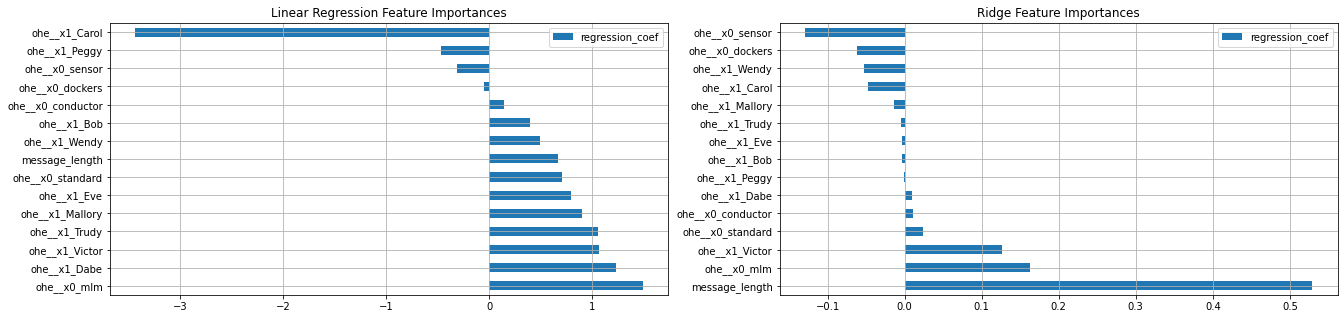

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(22, 5))
for i, model in enumerate([lr_pipe, lr_pipe_l2]):
  if i == 0:
    tit = 'Linear Regression'
  else:
    tit = 'Ridge'
  (
      pd.DataFrame(model['lr'].coef_, index=model['ct'].get_feature_names())
      .sort_values(by=0, ascending=False)
      .plot.barh(grid=True, title=f'{tit} Feature Importances', ax=ax[i])
  );
  ax[i].legend(['regression_coef']);

Если верить трактовке весов линейной регрессии, то количество багов в основном зависит от сотрудника и также от того, является ли репозиторий mlm.  
Если же верить Ridge регрессии, то наибольшую корреляцию количество багов имеет с длинной сообщения. В результате L2-регуляризации веса признаков, связанных с именами сотрудников были сильно уменьшены и практически сведены к нулю. При этом, качество предсказания практически не изменилось. Иными словами, получается, что вне зависимости от того, какой сотрудник делал коммит, наибольшее влияние на количество багов имеет то, насколько длинным было сообщение, которое оставлял сотрудник.

Следующим шагом посмотрим, какие результаты покажут нелинейные модели.

## 4.2 Random Forest

Оценим качество работы случайного леса.

In [66]:
rf = RandomForestRegressor(n_estimators=500, min_samples_leaf=5, max_features=0.33, random_state=1)
ct = ColumnTransformer(
    [('ordinal_encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=111), cat_columns)], remainder='passthrough')

rf_pipe = Pipeline([('ct', ct), ('rf', rf)])

rf_all_score = cross_val_score(rf_pipe, all_features, target, scoring='neg_root_mean_squared_error', error_score='raise', cv=10)
rf_word_score = cross_val_score(rf, word_features, target, scoring='neg_root_mean_squared_error', error_score='raise', cv=10)
rf_main_score = cross_val_score(rf_pipe, main_features, target, scoring='neg_root_mean_squared_error', error_score='raise', cv=10)

print('Random Forest / all_features:', -rf_all_score.mean())
print('Random Forest / text_features:', -rf_word_score.mean())
print('Random Forest / main_features:', -rf_main_score.mean())

Random Forest / all_features: 1.0770612239188666
Random Forest / text_features: 1.746579635000085
Random Forest / main_features: 1.0244864612058708


Модель случайного леса показала наилучший результат на признаках, которые не содержат текста коммита (`main_features`).

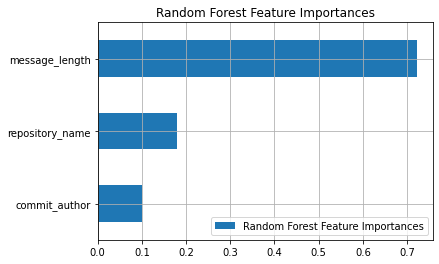

In [67]:
# Обучим случайный лес.
rf_pipe.fit(main_features, target)

# Посмотрим на важность признаков.
(
    pd.DataFrame(rf_pipe['rf'].feature_importances_, index=main_features.columns)
    .sort_values(by=0, ascending=True).
    plot.barh(grid=True, title='Random Forest Feature Importances')
);
plt.legend(['Random Forest Feature Importances']);

Обучим случайный лес на датасете с признаком, заполненным случайным числом. Так мы сможем проверить, действительно ли признаки `repository_name` и `commit_author` имеют влияние на количество багов.  
Если имеют - то их важность окажестя выше, чем важность случайной фичи.

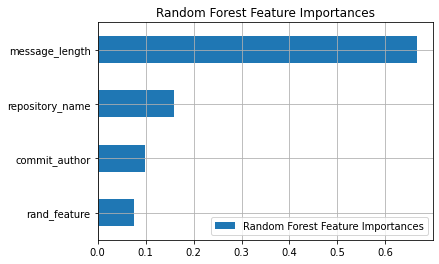

In [68]:
rf_pipe.fit(main_features_rand, target)

(
    pd.DataFrame(rf_pipe['rf'].feature_importances_, index=main_features_rand.columns)
    .sort_values(by=0, ascending=True).
    plot.barh(grid=True, title='Random Forest Feature Importances')
);
plt.legend(['Random Forest Feature Importances']);

Да, эти признаки имеют влияние на целевую переменную.

## 4.3 Gradient Boosting Machine

Посмотрим как покажет себя модель градиентного бустинга. Результат будем смотреть только на основных признаках (`main_features`), так как на основании прошлых проверок можно сделать вывод, что содержание текста с количеством багов никак не коррелирует.

In [ ]:
catboost = CatBoostRegressor(iterations=5000, random_seed=1)
cb_main_score = cross_val_score(
    catboost, main_features, target, cv=10, scoring='neg_root_mean_squared_error', error_score='raise', 
    fit_params={'cat_features': cat_columns, 'verbose': 0}
)

print('CatBoost / main_features:', -cb_main_score.mean())

CatBoost / main_features: 1.0451282853640458


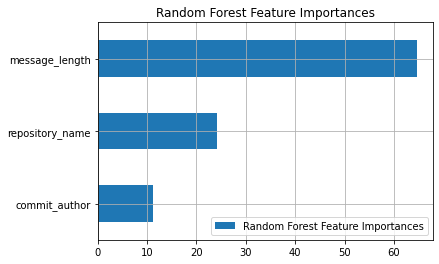

In [ ]:
# Обучим модель градиентного бустинга
catboost.fit(main_features, target, cat_features=cat_columns, verbose=0)

# Посмотрим на важность признаков
(
    pd.DataFrame(catboost.feature_importances_, index=main_features.columns)
    .sort_values(by=0, ascending=True).
    plot.barh(grid=True, title='Random Forest Feature Importances')
);
plt.legend(['Random Forest Feature Importances']);

Картина получилась та же самая, что и со случайным лесом. Наиболее важные признак - длина сообщения. Следущий по важности признак - название репозитория. И наименее важный - имя автора.

Интерпретируем предсказания модели с использованием библиотеки `shap`

In [ ]:
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(main_features)

Посмотрим на график для признака "длина сообщения".

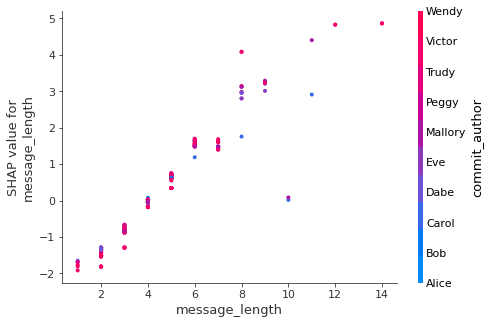

In [ ]:
shap.dependence_plot("message_length", shap_values, main_features)

На графике хорошо видно, что практически все сотрудники писали сообщения разной длины. При этом, чем больше длина, тем в большую сторону сдвигаются предсказания модели.

Посмотрим на график для признака "наименование репозитория"

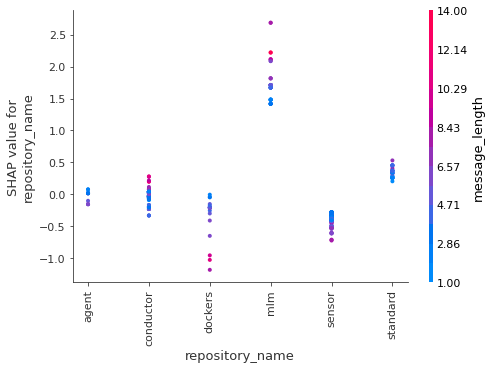

In [ ]:
shap.dependence_plot("repository_name", shap_values, main_features, interaction_index=2)

На этом графике можно заметить, что в репозитории mlm были  написаны сообщения разной длины (более того, в других репозиториях также присутствуют сообщения такой же длины, что и в mlm), однако сам факт того, что они были написаны в этом репозитории сдвигает предсказания модели в сторону большего количества багов.

Посмотрим на график для признака "автор коммита".

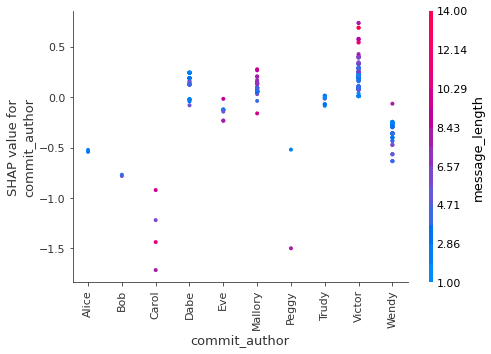

In [ ]:
shap.dependence_plot("commit_author", shap_values, main_features, interaction_index=2)

На этом графике видно, что вклад каждого автора в предсказанное количество багов минимален.  
Иными словами, не смотря на то, что присутствие некоторых сотрудников сдвигает предсказания модели в большую сторону, а присутствие иных - в меньшую, этот сдвиг очень мал и практически незначителен.

# 5. Скрипт для обучения модели.

Напишем скрипт для обучения модели.

In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import string
import nltk

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

nltk.download('wordnet')
nltk.download('punkt')

# Создадим функцию, которая будет разбивать текст на токены
def tokenize(text):
  list_of_tokens = list()

  for token in nltk.word_tokenize(text):
    if (token in string.punctuation) or (token in string.printable): 
      continue
    list_of_tokens.append(token)
  return list_of_tokens

# Создадим функцию для предобработки данных
def prepare_data(raw_dataset_features):
  prepared_features = raw_dataset_features.copy()
  prepared_features['message_length'] = prepared_features['commit_message'].apply(tokenize).apply(len)
  prepared_features = prepared_features.drop(['commit_hash', 'commit_date', 'commit_message'], axis=1)
  return prepared_features

# Создадим функцию, которая будет обучать модель случайного леса на данных
def fit_estimator(prepared_features, target):
  cat_columns = list(prepared_features.select_dtypes(include='object').columns)
  rf = RandomForestRegressor(n_estimators=500, min_samples_leaf=5, max_features=0.33, random_state=1)
  ct = ColumnTransformer(
    [('ordinal_encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=111), cat_columns)], remainder='passthrough')
  estimator = Pipeline([('ct', ct), ('rf', rf)])
  estimator.fit(prepared_features, target)
  return estimator

# Создадим функцию, которая будет создавать предсказания
def predict(estimator, test_data):
  predictions = estimator.predict(test_data)
  return predictions

# 6. Резюме

Целью данной работы являлось выявить зависимость числа `bugs` от значений признаков `repository_name`, `commit_hash`, `commit_date`, `commit_author` и `commit_message`, а также реализовать модель, на основе данного датасета, которая с максимальной точностью сможет предсказывать количество `bugs`.  

1. Первым этапом был произведен исследовательский анализ данных. В результате его проведения, было выявлено, что:
- Количество багов варьируется в зависимости от названия репозитория (`repository_name`)
- Количество багов варьируется в зависимости от автора коммита (`commit_author`)
- Наибольшее количество багов в основном наблюдалось у коммитов с более динными сообщениями. Коэффициент линейной корреляции Пирсона между количеством багов и длиной сообщения составляет 0.76.
- Среднее количество багов за весь период равняется 3-м. Максимальное количество багов - 12. Форма распределения количества багов близка к нормальному, однако имеет тяжелый хвост справа.
- Коммиты были сделаны в период с 8 марта 2020 года по 12 июня 2020 года.

Также, на основании проведенного анализа, было выдвинуто несколько предположений:
- Чем более длинное сообщение, тем больше ошибок будет в коммите.
- Количество ошибок (как и длина сообщения) может зависеть от сотрудника.
- Возможно, некоторые сотрудники допускают больше багов в одних репозиториях, нежели в других. При этом, есть вероятность того, что при коммите, содержащем баг, сотрудник напишет более длинное сообщение.

2. Следующим шагом была произведена предобработка данных. В результате предобработки данных:
- Была произведена токенизация, лемматизация столбца `commit_message`, предложения из данного столбца были преобразованы в onehot-encoded вектора.
- Был создан признак "длина сообщения" (`message_length`). 
- Были созданы несколько таблиц с признаками для обучения:
  - `word_features` - содержит матрицу с векторами предложений из столбца `commit_message`. 
  - `main_features` - содержит основные признаки (автор и репозиторий коммита, а также длина сообщения).
  - `all_features` - содержит все признаки.
  - `main_features_rand` - содержит основные признаки плюс 1 признак, заполненный случаными равномерно распределенными числами (создан для фильтрации важных признаков)

3. На следующем этапе была осуществлена оценка качества работы моделей машинного обучения.  
Были проверены 3 модели: 
- Линейная регрессия (без регуляризации, с L2-регуляризацией и с регуляризацией ElasticNet(0.5/0.5))
- Случайный лес
- Градиентный бустинг над деревьями   

Проверка производилась с использованием 10-fold кросс-валидации.   
Качество работы моделей оценивалось на различных наборах признаков. На оcновном наборе `main_features` (который включал в себя признаки "автор коммита", "репозиторий коммита", "длина сообщения"), а также на на веторизованном тексте `word_features`(векторизованные сообщения коммитов). Датасет `all_features` содержал все признаки из обоих вышеперечисленных датасетов.   

В ходе проверки моделей, были получены следующие результаты:  

|             | all_features |text_features| main_features |
|-------------|-----------|----------------|---------------|
|Ridge        | 1.09      |         1.77   |  1.09         |
|ElasticNet   |  1.17     |         1.78   |  1.17         |
|Linear Regression | 928614256.9 |  26852088056854.6  |  1.06 |
|Random Forest | 1.08    |     1.77        |  1.02        |
|CatBoost        |   -     |   -   |  1.05        |


Наилучший результат показала модель случайного леса на датасете `main_features`: RMSE = 1.02.   


Затем, была произведена интерпретация модели с использованием библиотеки `shap`.  

Наиболее информативными оказались признаки (в порядке убывания важности): 
- `message_length` ("длина сообщения"): чем больше длина, тем большее количество багов присутствует
- `repository_name` ("репозиторий коммита"): наибольшее количество багов содержится в репозитории "mlm"
- `commit_author` ("автор коммита")


Также, было выявлено, что слова, которые встречались в тексте коммита никак не коррелировали с количеством багов.  

В заключении работы, был написан скрипт для обучения модели случайного леса и расчета прогнозов.